In [31]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [0]:
import torch 
import torchvision
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import os
from PIL import Image
import glob
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import random
from bokeh.io import curdoc, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from functools import partial
from threading import Thread
from tornado import gen
import time
import pickle
from tqdm import tqdm
import torchvision.utils as vutils


#root folder
root_dir="/content/drive/My Drive/Fall 2019/Deep Learning CSE 676/Projects/1/DC Gans/"

#data directories
#output images
output_dir=root_dir+"output/epoch/"
#input images
input_dir=root_dir+"data/augmented/"

#models
model_dir=root_dir+"model/"
#other resources
res_dir=root_dir+"res/"
#report and logging
report_dir=root_dir+"report/"


#parameters
batch_size=100
train_split=0.8
train_epoch=50

#input
data_dir="data"
inp_width=32
inp_height=32
inp_channels=3
nc=3
nz=200

#generator
ngf=64
ndf=64

#discriminator
ndf=2

Importing logger to keep a track of training progress 

##utils

In [0]:

import itertools, imageio, torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
#from scipy.misc import imresize
#import PIL
#import pilutil


def ones_target(size):
  #returning tensor variable containing ones, with shape =size
  data=Variable(torch.ones(size,1))
  return data

def zeros_target(size):
  data=Variable(torch.zeros(size,1))
  return data

def images_to_vectors(images):
  return images.view(images.size(0),3072) #parameters: (size to flatten(28 here, row size), no. of images to be flattened)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0),3,32,32) # to convert each row of vectors to 28x28 pixels images 
# parameteres: (initial flattened dim, no. of sub vectors to be converted to 2d, 2d dimensions of output )

def show_result(G, x_, num_epoch, show = False, save = False, path = 'result.png'):
    # G.eval()
    y_ = G(x_)
    y_=y_[:4]
    y_ = y_.cpu()

    size_figure_grid = 3
    fig, ax = plt.subplots(x_.size()[0], size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(x_.size()[0]), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for i in range(y_.size()[0],2):

        ax[i, 0].cla()
        ax[i, 0].imshow((y_[i].numpy().transpose(1, 2, 0) + 1) / 2)
        ax[i, 1].cla()
        ax[i, 1].imshow((y_[i+1].numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def generate_animation(root, model, opt):
    images = []
    for e in range(opt.train_epoch):
        img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root + model + 'generate_animation.gif', images, fps=5)

def data_load(path, subfolder, transform, batch_size, shuffle=True):
    dset = datasets.ImageFolder(path, transform)
    ind = dset.class_to_idx[subfolder]

    n = 0
    for i in range(dset.__len__()):
        if ind != dset.imgs[n][1]:
            del dset.imgs[n]
            n -= 1

        n += 1

    return torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=shuffle)

def imgs_resize(imgs, resize_scale = 286):
    outputs = torch.FloatTensor(imgs.size()[0], imgs.size()[1], resize_scale, resize_scale)
    for i in range(imgs.size()[0]):
        img = imresize(imgs[i].numpy(), [resize_scale, resize_scale])
        outputs[i] = torch.FloatTensor((img.transpose(2, 0, 1).astype(np.float32).reshape(-1, imgs.size()[1], resize_scale, resize_scale) - 127.5) / 127.5)

    return outputs

def random_crop(imgs1, imgs2, crop_size = 256):
    outputs1 = torch.FloatTensor(imgs1.size()[0], imgs1.size()[1], crop_size, crop_size)
    outputs2 = torch.FloatTensor(imgs2.size()[0], imgs2.size()[1], crop_size, crop_size)
    for i in range(imgs1.size()[0]):
        img1 = imgs1[i]
        img2 = imgs2[i]
        rand1 = np.random.randint(0, imgs1.size()[2] - crop_size)
        rand2 = np.random.randint(0, imgs2.size()[2] - crop_size)
        outputs1[i] = img1[:, rand1: crop_size + rand1, rand2: crop_size + rand2]
        outputs2[i] = img2[:, rand1: crop_size + rand1, rand2: crop_size + rand2]

    return outputs1, outputs2

def random_fliplr(imgs1, imgs2):
    outputs1 = torch.FloatTensor(imgs1.size())
    outputs2 = torch.FloatTensor(imgs2.size())
    for i in range(imgs1.size()[0]):
        if torch.rand(1)[0] < 0.5:
            img1 = torch.FloatTensor(
                (np.fliplr(imgs1[i].numpy().transpose(1, 2, 0)).transpose(2, 0, 1).reshape(-1, imgs1.size()[1], imgs1.size()[2], imgs1.size()[3]) + 1) / 2)
            outputs1[i] = (img1 - 0.5) / 0.5
            img2 = torch.FloatTensor(
                (np.fliplr(imgs2[i].numpy().transpose(1, 2, 0)).transpose(2, 0, 1).reshape(-1, imgs2.size()[1], imgs2.size()[2], imgs2.size()[3]) + 1) / 2)
            outputs2[i] = (img2 - 0.5) / 0.5
        else:
            outputs1[i] = imgs1[i]
            outputs2[i] = imgs2[i]

    return outputs1, outputs2

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def noise(size):
  n=Variable(torch.randn(size,200))
  return n
 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

##Loading the CIFAR Data

0it [00:00, ?it/s]

170500096it [00:04, 38768824.60it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Size of train set 400
Size of val set 100
Size of test set 2500


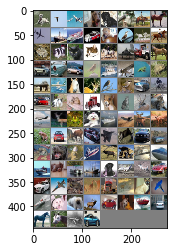

  dog  bird plane   dog   dog  bird horse horse plane  ship  ship   car   dog  bird horse horse  frog   dog   cat   cat horse plane truck horse   car   car   car  bird  ship plane  frog  frog plane plane horse  deer  bird  bird   car horse   car   cat   cat truck   dog   cat  deer   cat plane  deer  frog   dog  ship plane  deer  deer  frog   car  deer   car plane   cat   car   car   dog   dog  frog  ship  deer truck  ship plane  ship   cat  ship  ship   dog plane  deer   car   car plane  frog  deer truck  deer   cat plane  ship   dog   dog  deer   car   dog  ship   car horse horse plane   car
Size of images torch.Size([100, 3, 32, 32])


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
trainset, valset=torch.utils.data.random_split(dataset,[train_size,val_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Size of train set",len(trainloader))
print("Size of val set",len(valloader))
print("Size of test set",len(testloader))



# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print("Size of images",images.size())


Adding funcionality to flatten an image and vice versa. 
Flattening means to convert a multidimensional matrix to one dimensional

##model

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(200, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

            
    def forward(self, input):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
#             output = self.main(input)
        output = self.main(input)
        return output

class Discriminator(nn.Module):
    def __init__(self, ngpu=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
#             output = self.main(input)
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [0]:
num_test_samples=16
#generating test samples
test_noise=noise(num_test_samples)

##Training the Gan

In [0]:
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
from PIL import Image
#creating logger instance
num_epochs=50
num_batches = len(trainloader)
for epoch in range(num_epochs):
  for n_batch,(real_batch,_) in enumerate(trainloader):
    N=real_batch.size(0)
    
    #Train discriminator
    real_data=Variable(images_to_vectors(real_batch))
    #generate fake data and detach to avoid further calculation of gradients
    fake_data=generator(noise(N)).detach()
    
    #train
    d_error,d_pred_real,d_pred_fake=train_discriminator(d_optimizer, real_data, fake_data)
    
    #Train Generator
    #generate fake data
    fake_data=generator(noise(N))
    #train 
    g_error=train_generator(g_optimizer, fake_data)
    #Log batch error
    
    if(n_batch)%100==0: #??
      test_images=vectors_to_images(generator(test_noise))
      test_images=test_images.data
            
      #display status logs
      import matplotlib.pyplot as plt
      f, axarr = plt.subplots(2, 2)
      axarr[0, 0].imshow(test_images[0,0])
      axarr[0,1].imshow(test_images[1,0])
      axarr[1, 0].imshow(test_images[2,0])
      axarr[1, 1].imshow(test_images[3,0])
      # Fine-tune figure; make subplots farther from each other.
      f.subplots_adjust(hspace=0.3)

      plt.show()

In [0]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(test_images[0,0])
axarr[0,1].imshow(test_images[1,0])
axarr[1, 0].imshow(test_images[2,0])
axarr[1, 1].imshow(test_images[3,0])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)

plt.show()


https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


##From pix2pix model

In [35]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
print(len(dataset))
train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
train_dataset, val_dataset=torch.utils.data.random_split(dataset,[train_size,val_size])
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size,
                                             shuffle=True,
                                          num_workers=4)
num_batches=len(train_dataloader)
val_dataloader=torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                          num_workers=4)


#from model import generator, discriminator
#import utils

#parameters
lrG=0.02
lrD=0.02
beta1=0.5
beta2=0.999
L1_lambda=1.5



start_time=time.time()
epoch_start=0
epoch_end=epoch_start+train_epoch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = Generator(ngf)
D = Discriminator(ndf)
G_optimizer=optim.Adam(G.parameters(),lr=lrG,betas=(beta1,beta2))
D_optimizer=optim.Adam(D.parameters(),lr=lrD,betas=(beta1,beta2))
#loss
BCE_loss=nn.BCELoss().to(device)
L1_loss=nn.L1Loss().to(device)

#Loading the model if previously exists
if(os.path.isfile(model_dir+'generator_param.pkl') and os.path.isfile(model_dir+'discriminator_param.pkl')):

  G_checkpoint=torch.load(model_dir+'generator_param.pkl',map_location=device)
  D_checkpoint=torch.load(model_dir+'discriminator_param.pkl',map_location=device)
  G.load_state_dict(G_checkpoint['model_state_dict'])
  D.load_state_dict(D_checkpoint['model_state_dict'])
  G.to(device)
  D.to(device)
  G.train()
  D.train()
  #D.eval()

  G_optimizer.load_state_dict(G_checkpoint['optimizer_state_dict'])
  D_optimizer.load_state_dict(D_checkpoint['optimizer_state_dict'])

  train_hist=G_checkpoint['train_hist']
  epoch_start=G_checkpoint['epoch']
  epoch_end=epoch_start+train_epoch
#Esle creating new model
else:  
  print("Previous model not found. Restarting train process...")
  G.apply(weights_init)
  D.apply(weights_init)
  G.to(device)
  D.to(device)
  G.train()
  D.train()


  G_optimizer=optim.Adam(G.parameters(),lr=lrG,betas=(beta1,beta2))
  D_optimizer=optim.Adam(D.parameters(),lr=lrD,betas=(beta1,beta2))

  train_hist={}
  train_hist['D_losses']=[]
  train_hist['G_losses']=[]
  train_hist['per_epoch_ptimes']=[]
  train_hist['total_ptime']=[]
  epoch_start=0
  epoch_end=epoch_start+train_epoch

#training
for epoch in range(epoch_start,epoch_end):
  D_losses=[]
  G_losses=[]
  epoch_start_time=time.time()
  num_iter=0
  for (real_image, _) in train_dataloader:
    inp_noise=torch.randn(batch_size, nz, 1, 1, device=device)
    inp_noise,real_image=Variable(inp_noise.to(device)),Variable(real_image.to(device))
    D.zero_grad()

    D_result=D(real_image).squeeze()
    
    D_real_loss=BCE_loss(D_result,Variable(torch.ones(D_result.size()).to(device)))
    
    G_result=G(inp_noise)
    G_result=G_result.detach()
    D_result=D(G_result).squeeze()
    D_fake_loss=BCE_loss(D_result,Variable(torch.zeros(D_result.size()).to(device)))

    D_train_loss=(D_real_loss +D_fake_loss)*0.5
    D_train_loss.backward()
    D_optimizer.step()
    train_hist['D_losses'].append(float(D_train_loss))

    D_losses.append(float(D_train_loss))
    D_losses.append(float(0))

    #training generator
    G.zero_grad()

    G_result=G(inp_noise)
    G_result=G_result.detach()
    D_result=D(G_result).squeeze()
    G_train_loss=BCE_loss(D_result, Variable(torch.ones(D_result.size()).to(device))) + L1_lambda*L1_loss(G_result,real_image)
    G_train_loss.backward()
    G_optimizer.step()

    train_hist['G_losses'].append(float(G_train_loss))
    G_losses.append(float(G_train_loss))
    num_iter+=1

  torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': G_optimizer.state_dict(),
            'train_hist': train_hist
            }, model_dir+'generator_param.pkl')

  torch.save({
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': D_optimizer.state_dict(),
            },model_dir+'discriminator_param.pkl')

  epoch_end_time=time.time()
  per_epoch_ptime=epoch_end_time-epoch_start_time
  print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
  fixed_p =  output_dir  + str(epoch + 1) + '.png'
  save_noise=torch.randn(1, nz, 1, 1, device=device)
  #show_result(G, Variable(inp_noise.to(device), volatile=True), real_image.cpu(), (epoch+1), save=True, path=fixed_p)
  vutils.save_image(G(save_noise).detach(),
                    fixed_p,
                    normalize=True)
  train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time=time.time()
total_ptime=end_time-start_time
train_hist['total_ptime'].append(total_ptime)
print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))


with open(report_dir+'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=report_dir + 'train_hist.png')

Mounted at /content/drive/
50000
[9/50] - ptime: 16.17, loss_d: 0.000, loss_g: 11.577
[10/50] - ptime: 16.13, loss_d: 0.000, loss_g: 11.785
[11/50] - ptime: 16.07, loss_d: 0.000, loss_g: 11.964
[12/50] - ptime: 16.10, loss_d: 0.000, loss_g: 12.285
[13/50] - ptime: 16.03, loss_d: 0.000, loss_g: 12.588
[14/50] - ptime: 16.24, loss_d: 0.000, loss_g: 12.818


KeyboardInterrupt: ignored

In [0]:
os.path.isfile(model_dir+'generator_param.pkl')

False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


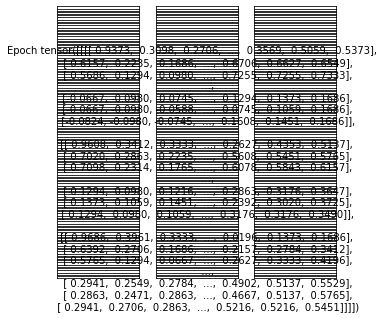

In [0]:
show_result(G, Variable(inp_noise.to(device), volatile=True), text_image.cpu(), (epoch+1), save=True, path="hello.png")